# Training a RL agent with Keras-RL2 using a GEM environment

This notebook serves as an educational introduction to the usage of Keras-RL2 using a GEM environment. Goal of this notebook is to give an understanding what Keras-RL2 is and how to use it to train and evaluate a Reinforcement Learning agent which is able to solve a current control problem of the GEM toolbox.

The following code snippets are only needed if you are executing this file directly from a cloned GitHub repository where you don't have GEM installed

In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent.parent))

## 1. What you need

Before you can start you need to make sure that you have both gym-electric-motor and Keras-rl2 installed. You can install both easily using pip:

- pip install gym-electric-motor
- pip install keras-rl2

Alternatively, you can install them and their latest developer version directly from GitHub:

- https://github.com/upb-lea/gym-electric-motor

You also need to make sure that numpy and gym are installed. You can install both using pip, too. After you have done that you should be able to execute the following cells without any problems.

## 2. Setting up a GEM evironment

This notebook does not focus directly on the usage of GEM and how to set up a GEM environment. If you are new to GEM and interested to find out what it does and how to use it we recommend taking a look at the educational notebook which is dealing with GEM.


For this notebook, we will use a function defined in an external Python file called setting_environment.py. If you are interested to see how we defined our environment's parameters you can take a look at that file. We are using the Discrete Permanent Magnet Synchronous Motor Environment:

- https://upb-lea.github.io/gym-electric-motor/parts/environments/pmsm_disc.html

- https://upb-lea.github.io/gym-electric-motor/parts/physical_systems/electric_motors/pmsm.html

The motor schematic is the following:

![Motor Setup](img/ESBdq1.svg)

And the electrical ODEs for that motor are:

<h3 align="center">

$\frac{\mathrm{d}i_{sq}}{\mathrm{d}t} = \frac{u_{sq}-pL_d\omega_{me}i_{sd}-R_si_{sq}}{L_q}$

$\frac{\mathrm{d}i_{sd}}{\mathrm{d}t} = \frac{u_{sd}-pL_q\omega_{me}i_{sq}-R_si_{sd}}{L_d}$

$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$

</h3>

In GEM the agent controls the converter who converts the supply currents to the currents flowing into the motor - in our motor's case $i_{sq}$ and $i_{sd}$:

![Motor Setup](img/SCML_Setting.svg)


In the continuous case the agent's action is controlling the converter's output voltage directly through means of duty cycling. In the discrete case the agent's action decides which converter switches are open and which are closed. Therefore, only a discrete amount of options are available. For this environment we are using the Discrete B6 Bridge Converter which has three switches which amounts to a total of eight possible actions the agent can take:

![Motor Setup](img/B6.svg)



We wish for an agent to be able to control the currents freely. For this a reference generator generates a trajectory which the agent has to follow. Therefore, it has to internally learn to solve the ODEs and convert voltages accordingly. The following code is using our pre-written function set_env to import our pre-defined GEM environment. We are also using the callback RewardLogger to visualize our training progress after training.

In [2]:
from setting_environment import set_env
env = set_env(training=True)

C:\Python 3.7\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 3. What is Keras-RL2?

keras-rl2 is a collection of Reinforcement Learning algorithms implementation. It can be used in a scenario where you want to train an agent of a specific RL algorithm when you don't want to implement the algorithm yourself.

Keras-rl2 is a widely used library for reinforcement learning. Most of the algorithms and their extensions are readily available and are quite stable.However, it is very vaguely implemented. But the ease of adopting to various environments makes it one of the widely used libraries.

For currently available RL algorithms see their documentation:

- https://keras-rl.readthedocs.io/en/latest/agents/overview/

## 4. Training an agent

To train an agent in Keras-rl2 you need two things: The agent and a function approximator representing the control policy. The agent is the algorithm you want to use to solve your problem. The policy defines the function estimation you want to use. Mostly supported are MLP and CNN function estimators. Check the algorithm in the documentation to see what estimator the algorithm you want to use supports. In the future, recurrent functions estimators are supposed to be implemented, too.

### 4.1 Imports

In our control problem we have an environment with a discrete action space. Therefore, we decided for the Deep-Q-Network (DQN):

- https://arxiv.org/abs/1312.5602

For the implementation of the DQN you can check the following github repository:

- https://github.com/keras-rl/keras-rl/blob/master/rl/agents/dqn.py#L89


In this tutorial we use MLP. Necessary Imports like importing DQNAgent from keras-rl2, policy and memory has to be imported
and it is important to Flatten observation, since Keras-rl doesn't support any other form of input. Currently, Feature engineering and invoking the environment are implemeneted in setting_environment.py. Hence it has to be imported too.

In [3]:
import sys, os
from pathlib import Path
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from setting_environment import set_env

### 4.2 Setting the parameters

For the DQN algorithm we have to define a set of values.These values will be directly used during compilation and training of an Agent

In [4]:
# Training parameters.
gamma = 0.99
time_limit = True
buffer_size = 200000  # number of old obersation steps saved
batch_size = 25  # mini batch size drawn at each update step
env = set_env(time_limit, gamma, N=0, M=0, training=True)
nb_actions = env.action_space.n
window_length = 1
model = Sequential()
model.add(Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))

memory = SequentialMemory(limit=200000, window_length=window_length)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(eps=0.2), 'eps', 1, 0.05, 0, 50000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\Python 3.7\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### 4.3 Starting the training

Once you've setup the environment and defined your parameters starting the training is nothing more than a one-liner. For each algorithm all you have to do is call its .fit() function. The advantage of keras-rl is that you can see all the important parameters and their values during training phase to get an intution of learning. Hence we donot need to implement any callbacks seperately.

In [5]:
dqn = DQNAgent(
    model=model,
    policy=policy,
    nb_actions=nb_actions,
    memory=memory,
    gamma=gamma,
    batch_size=25,
    train_interval=1,
    memory_interval=1,
    target_model_update=1000,
    nb_steps_warmup=10000,
    enable_double_dqn=True
)

dqn.compile(Adam(lr=1e-4),
            metrics=['mse']
            )

Training for 500000 steps ...


<IPython.core.display.Javascript object>


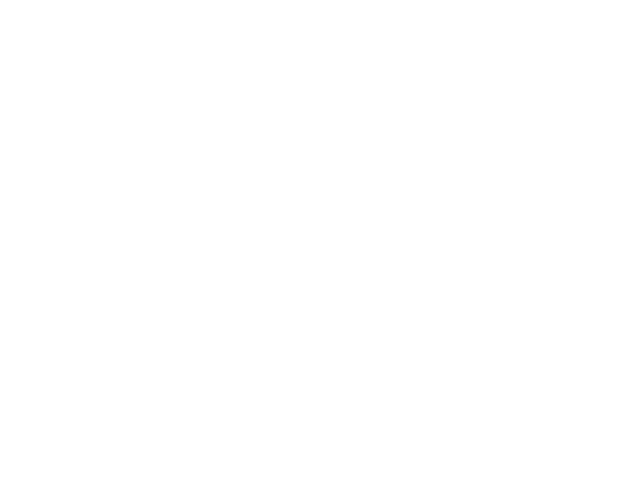

   4141/500000: episode: 1, duration: 3.632s, episode steps: 4141, steps per second: 1140, episode reward: -9123.564, mean reward: -2.203 [-2000.000, -0.012], mean action: 3.042 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
   5657/500000: episode: 2, duration: 1.141s, episode steps: 1516, steps per second: 1328, episode reward: -10600.551, mean reward: -6.992 [-2000.000, -0.056], mean action: 3.066 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
   7117/500000: episode: 3, duration: 1.062s, episode steps: 1460, steps per second: 1375, episode reward: -4488.118, mean reward: -3.074 [-2000.000, -0.026], mean action: 3.092 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
   8249/500000: episode: 4, duration: 0.857s, episode steps: 1132, steps per second: 1320, episode reward: -6119.202, mean reward: -5.406 [-2000.000, -0.051], mean action: 3.214 [0.000, 6.000],  loss: --, mse: --, mean_q: --, mean_eps: --
   8843/500000: episode: 5, duration: 0.479

  37284/500000: episode: 33, duration: 1.860s, episode steps: 360, steps per second: 194, episode reward: -3302.484, mean reward: -9.174 [-2000.000, -0.048], mean action: 2.950 [0.000, 6.000],  loss: 1160.069531, mse: 8033.850220, mean_q: -89.452234, mean_eps: 0.295034
  37639/500000: episode: 34, duration: 1.845s, episode steps: 355, steps per second: 192, episode reward: -3352.460, mean reward: -9.444 [-2000.000, -0.129], mean action: 2.541 [0.000, 6.000],  loss: 1940.558505, mse: 8540.581774, mean_q: -90.940437, mean_eps: 0.288241
  38027/500000: episode: 35, duration: 2.013s, episode steps: 388, steps per second: 193, episode reward: -3382.740, mean reward: -8.718 [-2000.000, -0.027], mean action: 1.985 [0.000, 6.000],  loss: 2281.476060, mse: 8714.988062, mean_q: -90.959197, mean_eps: 0.281183
  38315/500000: episode: 36, duration: 1.496s, episode steps: 288, steps per second: 192, episode reward: -3252.636, mean reward: -11.294 [-2000.000, -0.103], mean action: 1.983 [0.000, 6.00

 232854/500000: episode: 64, duration: 70.583s, episode steps: 10000, steps per second: 142, episode reward: -27379.918, mean reward: -2.738 [-5.570, -0.031], mean action: 2.254 [0.000, 6.000],  loss: 125.815696, mse: 20196.674126, mean_q: -145.100294, mean_eps: 0.050000
 242854/500000: episode: 65, duration: 66.515s, episode steps: 10000, steps per second: 150, episode reward: -25753.273, mean reward: -2.575 [-5.068, -0.053], mean action: 2.555 [0.000, 6.000],  loss: 85.758380, mse: 20000.530201, mean_q: -146.198795, mean_eps: 0.050000
 252854/500000: episode: 66, duration: 66.491s, episode steps: 10000, steps per second: 150, episode reward: -24306.603, mean reward: -2.431 [-6.961, -0.009], mean action: 1.813 [0.000, 6.000],  loss: 14.723228, mse: 19811.933015, mean_q: -148.058517, mean_eps: 0.050000
 262854/500000: episode: 67, duration: 66.516s, episode steps: 10000, steps per second: 150, episode reward: -25169.453, mean reward: -2.517 [-7.171, -0.040], mean action: 1.700 [0.000, 

In [6]:
%matplotlib notebook
dqn.fit(env,
        nb_steps=500000,
        action_repetition=1,
        verbose=2,
        visualize=True,
        nb_max_episode_steps=10000,
        log_interval=1000
        )

### 4.4 Saving the model

When the training is finished, you can save the model that your DQNAgent has learned to reuse it later, e.g. for evaluation or if you want to continue your training. For this, we use "____.save_weights".

In [7]:
dqn.save_weights('save_dqn_keras_jp.hdf5', overwrite=True)

## 5. Evaluating an agent

After you have trained your agent you would like to see how well it does on your control problem. For this you can for example look at a visual representation of your currents in a training phase.
in Testing phase, the widely used keras-rl2 has an edge since we have an option to control which values to be monitored throughout. Keras-rl DQN agent has its own "__.test" method which can be used to evaluate the performance of your agent 

Here the metric used is the total reward agent gets at the end of each episode. 

### 5.1 Loading a model

First, before we start our evaluation we have to load a trained agent or take the trained agent from the same code. To load an trained agent you only have to call the .load_weights(path) function of your algorithm with the respective path. 

If you are directly evaluating the performance(testing), note that the agent has to be compiled first(as shown in some cells above)

In [8]:
dqn.load_weights('save_dqn_keras_jp.hdf5')

Testing for 5 episodes ...


C:\Python 3.7\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


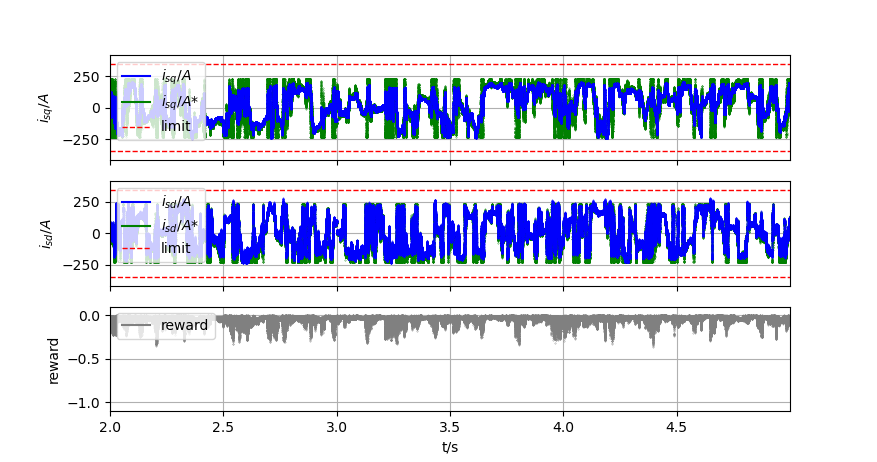

Episode 1: reward: -5039.575, steps: 100000
Episode 2: reward: -4570.522, steps: 100000
Episode 3: reward: -4958.910, steps: 100000
Episode 4: reward: -4325.067, steps: 100000
Episode 5: reward: -4000.296, steps: 100000


In [9]:
%matplotlib notebook
env = set_env(time_limit = False, gamma=0.99, N=0, M=0, training=False)
dqn.test(env,
         nb_episodes=5,
         nb_max_episode_steps=100000,
         visualize=True
         )